# Download dataset from kaggle

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c gan-getting-started

 93% 342M/367M [00:01<00:00, 284MB/s]
100% 367M/367M [00:01<00:00, 269MB/s]


In [ ]:
!unzip /content/gan-getting-started.zip

Streaming output truncated to the last 5000 lines.
  inflating: photo_jpg/46e71a4094.jpg  
  inflating: photo_jpg/46e84039a1.jpg  
  inflating: photo_jpg/46f391abec.jpg  
  inflating: photo_jpg/46f5ef1042.jpg  
  inflating: photo_jpg/4706619607.jpg  
  inflating: photo_jpg/4707b03a08.jpg  
  inflating: photo_jpg/47100a9939.jpg  
  inflating: photo_jpg/471f4755b9.jpg  
  inflating: photo_jpg/472b351bc4.jpg  
  inflating: photo_jpg/472d5ac100.jpg  
  inflating: photo_jpg/4758e5dd4c.jpg  
  inflating: photo_jpg/4762bb79ef.jpg  
  inflating: photo_jpg/4778b13518.jpg  
  inflating: photo_jpg/4787b82d37.jpg  
  inflating: photo_jpg/478e07feaa.jpg  
  inflating: photo_jpg/478eb12a82.jpg  
  inflating: photo_jpg/479698b371.jpg  
  inflating: photo_jpg/4796d67f61.jpg  
  inflating: photo_jpg/47aad493bd.jpg  
  inflating: photo_jpg/47ae0edd23.jpg  
  inflating: photo_jpg/47b94957ff.jpg  
  inflating: photo_jpg/47bb43fe3e.jpg  
  inflating: photo_jpg/47bb59d449.jpg  
  inflating: photo_jpg/47d391

# import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.utils import save_image

# models

In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

class GeneratorResNet(nn.Module):
    def __init__(self, input_channels, output_channels, num_residuals=12, base_channels=64):
        super(GeneratorResNet, self).__init__()
        # Initial Convolution Block with Extra Depth
        self.initial = nn.Sequential(
            nn.Conv2d(input_channels, base_channels, kernel_size=7, stride=1, padding=3, bias=False),
            nn.InstanceNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(base_channels),
            nn.ReLU(inplace=True)
        )

        # Downsampling with Additional Depth
        self.downsampling = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(base_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 2, base_channels * 4, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 4, base_channels * 8, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(base_channels * 8),
            nn.ReLU(inplace=True)
        )

        # Residual Blocks
        self.residuals = nn.Sequential(*[ResidualBlock(base_channels * 8) for _ in range(num_residuals)])

        # Upsampling with Additional Depth
        self.upsampling = nn.Sequential(
            nn.ConvTranspose2d(base_channels * 8, base_channels * 4, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.InstanceNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.InstanceNorm2d(base_channels * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.InstanceNorm2d(base_channels),
            nn.ReLU(inplace=True)
        )

        # Final Output Block with Extra Depth
        self.final = nn.Sequential(
            nn.Conv2d(base_channels, base_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, output_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsampling(x)
        x = self.residuals(x)
        x = self.upsampling(x)
        return self.final(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()
        def discriminator_block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(input_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)


# loss functions and optimizers

In [ ]:
adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()
reconstruction_loss = nn.L1Loss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G_AB = GeneratorResNet(3, 3).to(device)
G_BA = GeneratorResNet(3, 3).to(device)
D_A = Discriminator(3).to(device)
D_B = Discriminator(3).to(device)

# pre-trained models available
# G_AB.load_state_dict(torch.load("first-G_AB.pth"))
# G_BA.load_state_dict(torch.load("first-G_BA.pth"))
# D_A.load_state_dict(torch.load("first-D_A.pth"))
# D_B.load_state_dict(torch.load("first-D_B.pth"))

optimizer_G = optim.Adam(list(G_AB.parameters()) + list(G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0001, betas=(0.5, 0.999))

# training function

In [ ]:
def train_cycle_gan(dataloader, epochs):
    best = 10000
    for epoch in range(epochs):
        for i, (real_A, real_B) in enumerate(dataloader):
            real_A, real_B = real_A.to(device), real_B.to(device)

            # Train Generators
            optimizer_G.zero_grad()

            # Identity loss
            id_A = G_BA(real_A)
            id_B = G_AB(real_B)
            loss_id_A = identity_loss(id_A, real_A)
            loss_id_B = identity_loss(id_B, real_B)

            # Adversarial loss
            fake_B = G_AB(real_A)
            pred_fake_B = D_B(fake_B)
            loss_adv_B = adversarial_loss(pred_fake_B, torch.ones_like(pred_fake_B))

            fake_A = G_BA(real_B)
            pred_fake_A = D_A(fake_A)
            loss_adv_A = adversarial_loss(pred_fake_A, torch.ones_like(pred_fake_A))

            # Cycle consistency loss
            recov_A = G_BA(fake_B)
            recov_B = G_AB(fake_A)
            loss_cycle_A = cycle_loss(recov_A, real_A)
            loss_cycle_B = cycle_loss(recov_B, real_B)

            loss_reconstruction_A = reconstruction_loss(G_AB(real_A), real_A)
            loss_reconstruction_B = reconstruction_loss(G_BA(real_B), real_B)

            loss_G = (
                5*loss_id_A + 5*loss_id_B +
                loss_adv_A + loss_adv_B +
                10*loss_cycle_A + 10*loss_cycle_B
                + 10*loss_reconstruction_A + 10*loss_reconstruction_B
            )
            loss_G.backward()
            optimizer_G.step()

            # Train Discriminator A
            optimizer_D_A.zero_grad()
            pred_real_A = D_A(real_A)
            pred_fake_A = D_A(fake_A.detach())
            loss_D_A = 0.5 * (adversarial_loss(pred_real_A, torch.ones_like(pred_real_A)) +
                              adversarial_loss(pred_fake_A, torch.zeros_like(pred_fake_A)))
            loss_D_A.backward()
            optimizer_D_A.step()

            # Train Discriminator B
            optimizer_D_B.zero_grad()
            pred_real_B = D_B(real_B)
            pred_fake_B = D_B(fake_B.detach())
            loss_D_B = 0.5 * (adversarial_loss(pred_real_B, torch.ones_like(pred_real_B)) +
                              adversarial_loss(pred_fake_B, torch.zeros_like(pred_fake_B)))
            loss_D_B.backward()
            optimizer_D_B.step()

            # Print progress
            if i % 1 == 0:
                print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] "
                      f"[D_A loss: {loss_D_A.item()}] [D_B loss: {loss_D_B.item()}] "
                      f"[G loss: {loss_G.item()}]")

            # save best model
            if loss_G.item() < best:
                best = loss_G.item()
                torch.save(G_AB.state_dict(), 'best-G_AB.pth')
                torch.save(G_BA.state_dict(), 'best-G_BA.pth')
                torch.save(D_A.state_dict(), 'best-D_A.pth')
                torch.save(D_B.state_dict(), 'best-D_B.pth')


In [ ]:
import os
from PIL import Image

# dataset

In [ ]:
class MonetDataset(Dataset):
    def __init__(self, root_dir_A, root_dir_B, transform=None):
        self.files_A = os.listdir(root_dir_A)
        self.files_B = os.listdir(root_dir_B)
        self.root_dir_A = root_dir_A
        self.root_dir_B = root_dir_B
        self.transform = transform

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

    def __getitem__(self, idx):
        img_A = Image.open(os.path.join(self.root_dir_A, self.files_A[idx % len(self.files_A)]))
        img_B = Image.open(os.path.join(self.root_dir_B, self.files_B[idx % len(self.files_B)]))

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return img_A, img_B

transform = transforms.Compose([
    transforms.Resize((128, 128)),               # Resize images to 128x128
    transforms.RandomHorizontalFlip(p=0.5),     # Randomly flip images horizontally
    transforms.RandomRotation(degrees=15),      # Randomly rotate images within ±15 degrees
    transforms.ColorJitter(brightness=0.2,      # Randomly change brightness
                           contrast=0.2,        # Randomly change contrast
                           saturation=0.2,      # Randomly change saturation
                           hue=0.1),            # Randomly change hue
    transforms.RandomAffine(degrees=10,         # Random affine transformations
                            translate=(0.1, 0.1),  # Randomly translate within 10% of image size
                            scale=(0.9, 1.1),      # Randomly scale within 90%-110%
                            shear=5),              # Random shear up to 5 degrees
    transforms.ToTensor(),                      # Convert image to a PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))        # Normalize to [-1, 1]
])

dataset = MonetDataset("/content/monet_jpg", "/content/photo_jpg", transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [ ]:
class MonetDataset(Dataset):
    def __init__(self, root_dir_A, root_dir_B, transform=None):
        self.files_A = os.listdir(root_dir_A)
        self.files_B = os.listdir(root_dir_B)
        self.root_dir_A = root_dir_A
        self.root_dir_B = root_dir_B
        self.transform = transform

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

    def __getitem__(self, idx):
        img_A = Image.open(os.path.join(self.root_dir_A, self.files_A[idx % len(self.files_A)]))
        img_B = Image.open(os.path.join(self.root_dir_B, self.files_B[idx % len(self.files_B)]))

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return img_A, img_B

transform = transforms.Compose([
    transforms.Resize((128, 128)),               # Resize images to 128x128
    transforms.ToTensor(),                      # Convert image to a PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))        # Normalize to [-1, 1]
])

dataset = MonetDataset("/content/monet_jpg", "/content/photo_jpg", transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


# training

In [ ]:
train_cycle_gan(dataloader, epochs=1)


[Epoch 0/1] [Batch 0/441] [D_A loss: 0.12619540095329285] [D_B loss: 0.1778293401002884] [G loss: 6.498570919036865]
[Epoch 0/1] [Batch 1/441] [D_A loss: 0.2756997346878052] [D_B loss: 0.22594422101974487] [G loss: 6.548069953918457]
[Epoch 0/1] [Batch 2/441] [D_A loss: 0.21495111286640167] [D_B loss: 0.15415480732917786] [G loss: 6.020659446716309]
[Epoch 0/1] [Batch 3/441] [D_A loss: 0.12307766824960709] [D_B loss: 0.12417838722467422] [G loss: 5.772961616516113]
[Epoch 0/1] [Batch 4/441] [D_A loss: 0.22726741433143616] [D_B loss: 0.2122979462146759] [G loss: 5.8180832862854]
[Epoch 0/1] [Batch 5/441] [D_A loss: 0.17595426738262177] [D_B loss: 0.2336006909608841] [G loss: 5.6240057945251465]
[Epoch 0/1] [Batch 6/441] [D_A loss: 0.1439957618713379] [D_B loss: 0.22998538613319397] [G loss: 5.964535713195801]
[Epoch 0/1] [Batch 7/441] [D_A loss: 0.21912984549999237] [D_B loss: 0.13915130496025085] [G loss: 5.727097988128662]
[Epoch 0/1] [Batch 8/441] [D_A loss: 0.16189044713974] [D_B lo

In [ ]:
best_model = GeneratorResNet(3, 3).to(device)
best_model.load_state_dict(torch.load('best-G_BA.pth'))


<ipython-input-31-016a41db8633>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best-G_BA.pth'))


<All keys matched successfully>

torch.Size([16, 3, 128, 128])
torch.Size([16, 3, 128, 128])


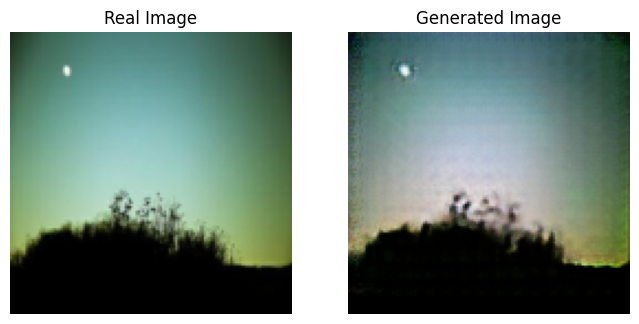

torch.Size([16, 3, 128, 128])
torch.Size([16, 3, 128, 128])


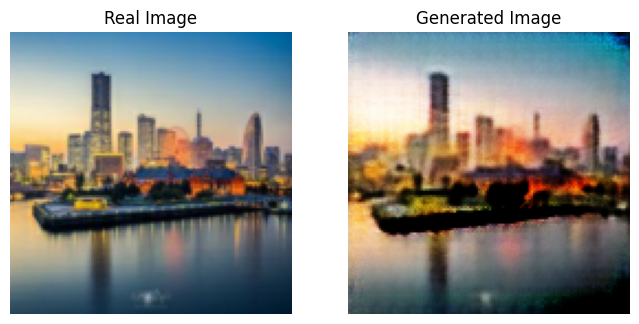

torch.Size([16, 3, 128, 128])
torch.Size([16, 3, 128, 128])


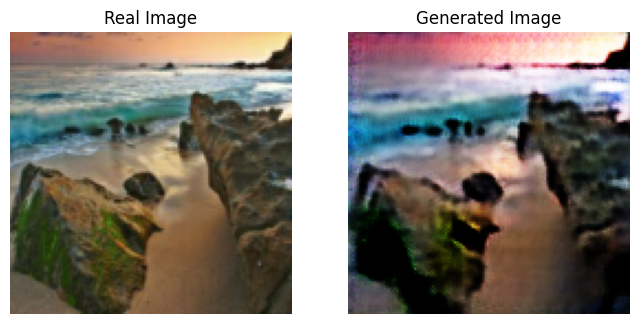

torch.Size([16, 3, 128, 128])
torch.Size([16, 3, 128, 128])


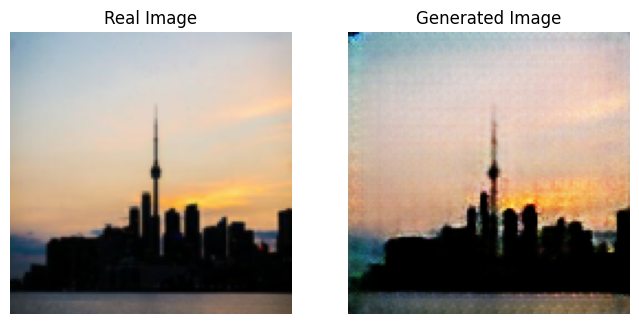

torch.Size([16, 3, 128, 128])
torch.Size([16, 3, 128, 128])


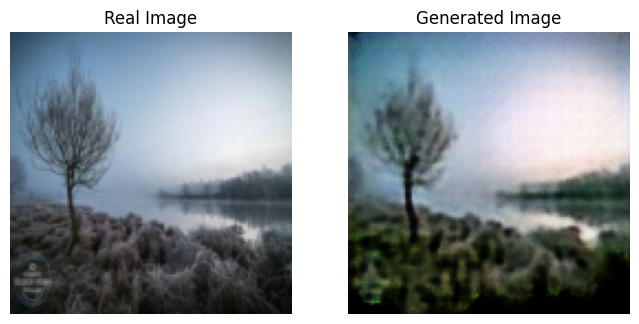

In [ ]:
import matplotlib.pyplot as plt

# Function to denormalize images from [-1, 1] to [0, 1] for visualization
def denormalize(tensor):
    return (tensor * 0.5) + 0.5

# Generate images using the trained generator
def generate_images(generator, generator2, dataloader, output_dir_real, output_dir_fake, num_images=5, device="cuda"):
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():  # No gradient calculation needed
        for i, (_, real_image) in enumerate(dataloader):
            real_image = real_image.to(device)

            # Generate the fake image
            fake_image = generator(real_image)


            # Denormalize for visualization
            real_image = denormalize(real_image)
            fake_image = denormalize(fake_image)

            print(real_image.shape)
            print(fake_image.shape)


            # Save real and fake images
            save_image(real_image, f"{output_dir_real}/real_image_{i}.png")
            save_image(fake_image, f"{output_dir_fake}/fake_image_{i}.png")

            # Visualize the first few images
            if i < num_images:
                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.title("Real Image")
                plt.imshow(real_image[0].cpu().permute(1, 2, 0).numpy())
                plt.axis("off")

                plt.subplot(1, 2, 2)
                plt.title("Generated Image")
                plt.imshow(fake_image[0].cpu().permute(1, 2, 0).numpy())
                plt.axis("off")

                plt.show()
            if i >= num_images - 1:
                break

# Example usage
# Assuming `G_AB` is the generator (e.g., real photo to Monet style)
# and `dataloader` is a DataLoader for the real photos
generate_images(G_AB, G_AB, dataloader, output_dir_real="/content/photo_jpg", output_dir_fake="fake_images", num_images=5, device=device)


In [ ]:
# save model
torch.save(G_AB.state_dict(), 'new4-G_AB.pth')
torch.save(G_BA.state_dict(), 'new4-G_BA.pth')
torch.save(D_A.state_dict(), 'new4-D_A.pth')
torch.save(D_B.state_dict(), 'new4-D_B.pth')

In [ ]:
output_dir = "all_fake_images/"

In [ ]:
# save all fake photos to directory to submit

G_BA.eval()
with torch.no_grad():
    i = 0
    for batch in dataloader:
        real_images = batch[1].to(device)
        for real_image in real_images:
            fake_image = G_BA(real_image.unsqueeze(0)).squeeze(0)
            fake_image = denormalize(fake_image)
            save_image(fake_image, f"{output_dir}/fake_image_{i}.jpg")
            print(f"Saved fake_image_{i}.jpg")
            i += 1

Streaming output truncated to the last 5000 lines.
Saved fake_image_2043.jpg
Saved fake_image_2044.jpg
Saved fake_image_2045.jpg
Saved fake_image_2046.jpg
Saved fake_image_2047.jpg
Saved fake_image_2048.jpg
Saved fake_image_2049.jpg
Saved fake_image_2050.jpg
Saved fake_image_2051.jpg
Saved fake_image_2052.jpg
Saved fake_image_2053.jpg
Saved fake_image_2054.jpg
Saved fake_image_2055.jpg
Saved fake_image_2056.jpg
Saved fake_image_2057.jpg
Saved fake_image_2058.jpg
Saved fake_image_2059.jpg
Saved fake_image_2060.jpg
Saved fake_image_2061.jpg
Saved fake_image_2062.jpg
Saved fake_image_2063.jpg
Saved fake_image_2064.jpg
Saved fake_image_2065.jpg
Saved fake_image_2066.jpg
Saved fake_image_2067.jpg
Saved fake_image_2068.jpg
Saved fake_image_2069.jpg
Saved fake_image_2070.jpg
Saved fake_image_2071.jpg
Saved fake_image_2072.jpg
Saved fake_image_2073.jpg
Saved fake_image_2074.jpg
Saved fake_image_2075.jpg
Saved fake_image_2076.jpg
Saved fake_image_2077.jpg
Saved fake_image_2078.jpg
Saved fake_im

In [ ]:
# delete output_dir
!rm -rf /content/all_fake_images/

In [ ]:
# create output_dir
!mkdir /content/all_fake_images/

In [ ]:
# duplicate output_dir
!cp -r /content/all_fake_images2 /content/all_fake_images/

cp: cannot stat '/content/all_fake_images2': No such file or directory


In [ ]:
# resize photos in output_dir to 256x256x3 (RGB)
from PIL import Image
import os

output_dir = "all_fake_images/"
target_size = (256, 256)

for filename in os.listdir(output_dir):
    if filename.endswith(".jpg"):
        image_path = os.path.join(output_dir, filename)
        img = Image.open(image_path)
        img = img.resize(target_size, Image.LANCZOS)
        img.save(image_path)
        print(f"Resized {filename} to {target_size}")

Streaming output truncated to the last 5000 lines.
Resized fake_image_5094.jpg to (256, 256)
Resized fake_image_3672.jpg to (256, 256)
Resized fake_image_2188.jpg to (256, 256)
Resized fake_image_6246.jpg to (256, 256)
Resized fake_image_1762.jpg to (256, 256)
Resized fake_image_4848.jpg to (256, 256)
Resized fake_image_1189.jpg to (256, 256)
Resized fake_image_3752.jpg to (256, 256)
Resized fake_image_4515.jpg to (256, 256)
Resized fake_image_461.jpg to (256, 256)
Resized fake_image_1621.jpg to (256, 256)
Resized fake_image_4435.jpg to (256, 256)
Resized fake_image_5734.jpg to (256, 256)
Resized fake_image_5975.jpg to (256, 256)
Resized fake_image_1540.jpg to (256, 256)
Resized fake_image_4025.jpg to (256, 256)
Resized fake_image_1718.jpg to (256, 256)
Resized fake_image_1972.jpg to (256, 256)
Resized fake_image_3098.jpg to (256, 256)
Resized fake_image_2320.jpg to (256, 256)
Resized fake_image_3311.jpg to (256, 256)
Resized fake_image_6247.jpg to (256, 256)
Resized fake_image_3003.jp

In [ ]:
# zip output_dir
!zip -r /content/all_fake_images3.zip /content/all_fake_images/

Streaming output truncated to the last 5000 lines.
  adding: content/all_fake_images/fake_image_5094.jpg (deflated 1%)
  adding: content/all_fake_images/fake_image_3672.jpg (deflated 1%)
  adding: content/all_fake_images/fake_image_2188.jpg (deflated 1%)
  adding: content/all_fake_images/fake_image_6246.jpg (deflated 1%)
  adding: content/all_fake_images/fake_image_1762.jpg (deflated 2%)
  adding: content/all_fake_images/fake_image_4848.jpg (deflated 1%)
  adding: content/all_fake_images/fake_image_1189.jpg (deflated 1%)
  adding: content/all_fake_images/fake_image_3752.jpg (deflated 1%)
  adding: content/all_fake_images/fake_image_4515.jpg (deflated 1%)
  adding: content/all_fake_images/fake_image_461.jpg (deflated 1%)
  adding: content/all_fake_images/fake_image_1621.jpg (deflated 1%)
  adding: content/all_fake_images/fake_image_4435.jpg (deflated 1%)
  adding: content/all_fake_images/fake_image_5734.jpg (deflated 1%)
  adding: content/all_fake_images/fake_image_5975.jpg (deflated 2%